(regression_discontinuity)=
# Regression discontinuity design analysis

:::{post} April, 2022
:tags: regression, causal inference, quasi experiments, counterfactuals 
:category: beginner, explanation
:author: Benjamin T. Vincent
:::

[Quasi experiments](https://en.wikipedia.org/wiki/Quasi-experiment) involve experimental interventions and quantitative measures. However, quasi-experiments do _not_ involve random assignment of units (e.g. cells, people, companies, schools, states) to test or control groups. This inability to conduct random assignment poses problems when making causal claims as it makes it harder to argue that any difference between a control and test group are because of an intervention and not because of a confounding factor.

The [regression discontinuity design](https://en.wikipedia.org/wiki/Regression_discontinuity_design) is a particular form of quasi experimental design. It consists of a control and test group, but assignment of units to conditions is chosen based upon a threshold criteria, not randomly. 

:::{figure-md} fig-target

![regression discontinuity design schematic](regression_discontinuity.png)

A schematic diagram of the regression discontinuity design. The dashed green line shows where we would have expected the post test scores of the test group to be if they had not received the treatment. Image taken from [https://conjointly.com/kb/regression-discontinuity-design/](https://conjointly.com/kb/regression-discontinuity-design/).
:::

Units with very low scores are likely to differ systematically along some dimensions than units with very high scores. For example, if we look at students who achieve the highest, and students who achieve the lowest, in all likelihood there are confounding variables. Students with high scores are likely to have come from more privileged backgrounds than those with the lowest scores. 

If we gave extra tuition (our experimental intervention) to students scoring in the lowest half of scores then we can easily imagine that we have large differences in some measure of privilege between test and control groups. At a first glance, this would seem to make the regression discontinuity design useless - the whole point of random assignment is to reduce or eliminate systematic biases between control and test groups. But use of a threshold would seem to maximise the differences in confounding variables between groups. Isn't this an odd thing to do?

The key point however is that it is much less likely that students scoring just below and just above the threshold systematically differ in their degree of privilege. And so _if_ we find evidence of a meaningful discontinuity in a post-test score in those just above and just below the threshold, then it is much more plausible that the intervention (applied according to the threshold criteria) was causally responsible.

## Sharp v.s. fuzzy regression discontinuity designs
Note that regression discontinuity designs fall into two categories. This notebook focuses on _sharp_ regression discontinuity designs, but it is important to understand both sharp and fuzzy variants:

- **Sharp:** Here, the assignment to control or treatment groups is purely dictated by the threshold. There is no uncertainty in which units are in which group.
- **Fuzzy:** In some situations there may not be a sharp boundary between control and treatment based upon the threshold. This could happen for example if experimenters are not strict in assigning units to groups based on the threshold. Alternatively, there could be non-compliance on the side of the actual units being studied. For example, patients may not always be fully compliant in taking medication, so some unknown proportion of patients assigned to the test group may actually be in the control group because of non compliance.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Generate simulated data
Note that here we assume that there is negligible/zero measurement noise, but that there is some variability in the true values from pre- to post-test. It is possible to take into account measurement noise on the pre- and post-test results, but we do not engage with that in this notebook.

In [3]:
# define true parameters
threshold = 0.0
treatment_effect = 0.7
N = 1000
sd = 0.3  # represents change between pre and post test with zero measurement error

# No measurement error, but random change from pre to post
df = (
    pd.DataFrame.from_dict({"x": rng.normal(size=N)})
    .assign(treated=lambda x: x.x < threshold)
    .assign(y=lambda x: x.x + rng.normal(loc=0, scale=sd, size=N) + treatment_effect * x.treated)
)

df

,x,treated,y
0,-0.989121,True,0.050794
1,-0.367787,True,-0.181418
2,1.287925,False,1.345912
3,0.193974,False,0.430915
4,0.920231,False,1.229825
...,...,...,...
995,-1.246726,True,-0.819665
996,0.090428,False,0.006909
997,0.370658,False,-0.027703
998,-1.063268,True,0.008132


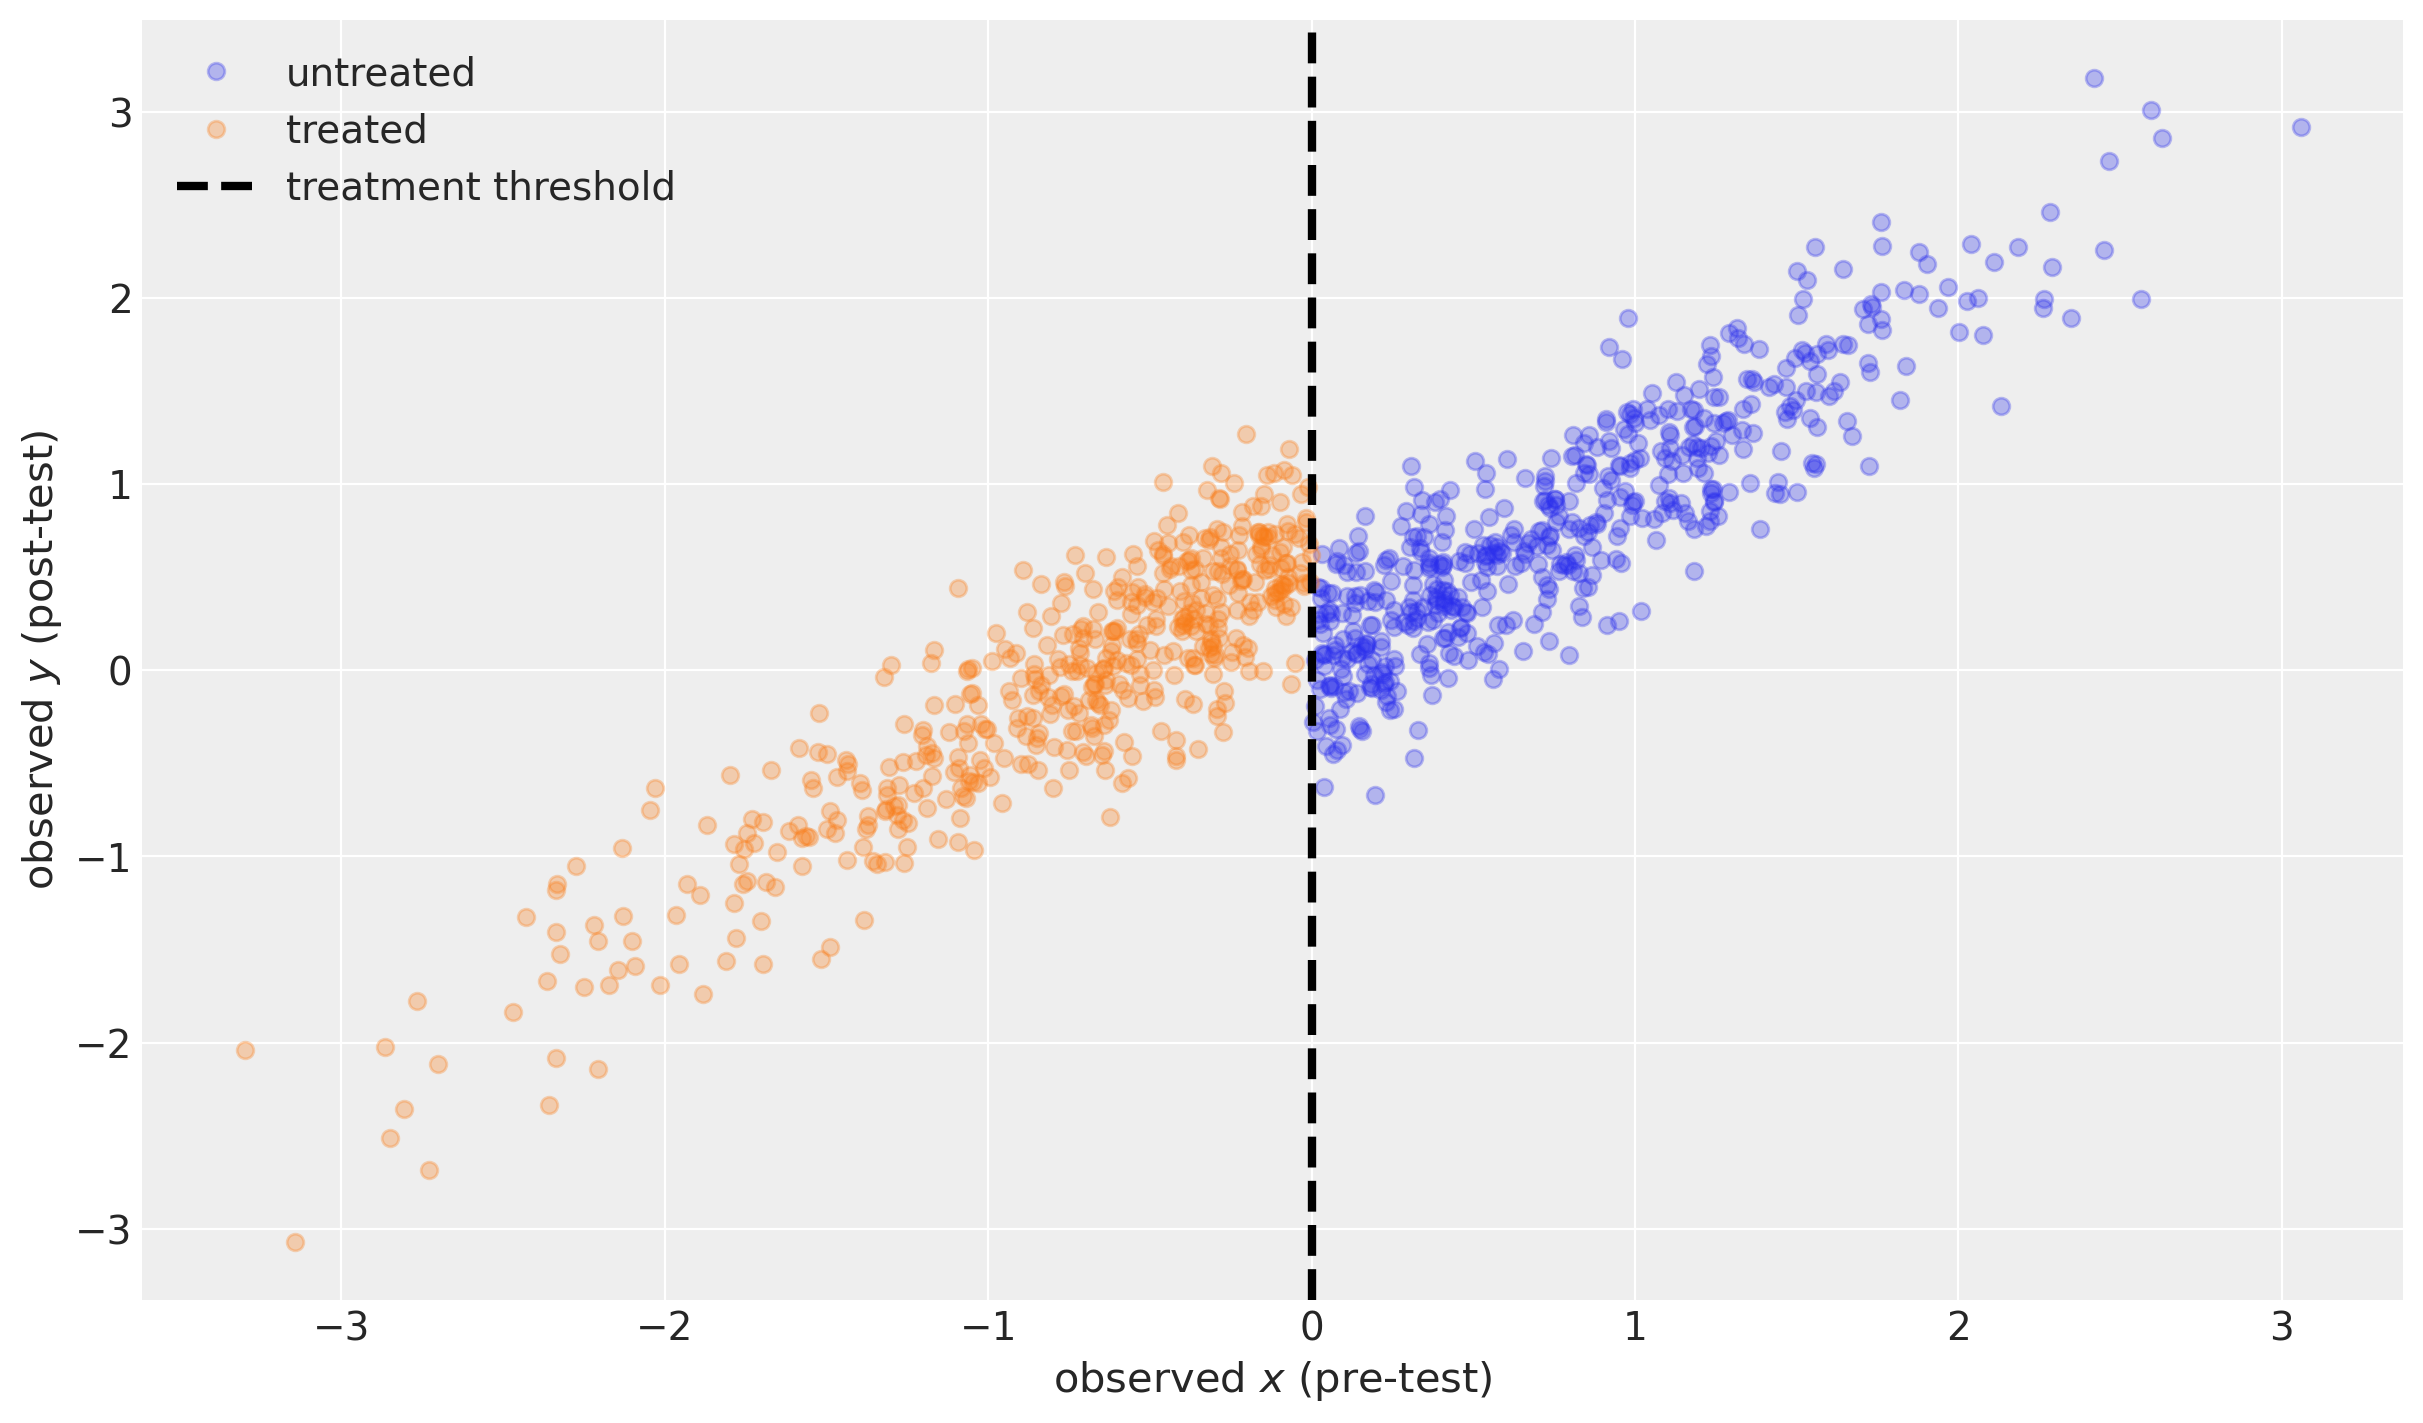

In [4]:
def plot_data(df):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(df.x[~df.treated], df.y[~df.treated], "o", alpha=0.3, label="untreated")
    ax.plot(df.x[df.treated], df.y[df.treated], "o", alpha=0.3, label="treated")
    ax.axvline(x=threshold, color="k", ls="--", lw=3, label="treatment threshold")
    ax.set(xlabel=r"observed $x$ (pre-test)", ylabel=r"observed $y$ (post-test)")
    ax.legend()
    return ax


plot_data(df);

## Sharp regression discontinuity model

We can define our Bayesian regression discontinuity model as:

$$
\begin{aligned}
\Delta & \sim \text{Cauchy}(0, 1) \\
\sigma & \sim \text{HalfNormal}(0, 1) \\
\mu & = x_i + \underbrace{\Delta \cdot treated_i}_{\text{treatment effect}} \\
y_i & \sim \text{Normal}(\mu, \sigma)
\end{aligned}
$$

where:
- $\Delta$ is the size of the discontinuity, 
- $\sigma$ is the standard deviation of change in the pre- to post-test scores,
- $x_i$ and $y_i$ are observed pre- and post-test measures for unit $i$, and 
- $treated_i$ is an observed indicator variable (0 for control group, 1 for test group).

Notes:
- We make the simplifying assumption of no measurement error.
- Here, we confine ourselves to the situation where we use the same measure (e.g. heart rate, educational attainment, upper arm circumference) for both the pre-test ($x$) and post-test ($y$). So the _untreated_ post-test measure can be modelled as $y \sim \text{Normal}(\mu=x, \sigma)$. 
- In the case that the pre- and post-test measuring instruments where not identical, then we would want to build slope and intercept parameters into $\mu$ to capture the 'exchange rate' between the pre- and post-test measures.
- We assume we have accurately observed whether a unit has been treated or not. That is, this model assumes a sharp discontinuity with no uncertainty.

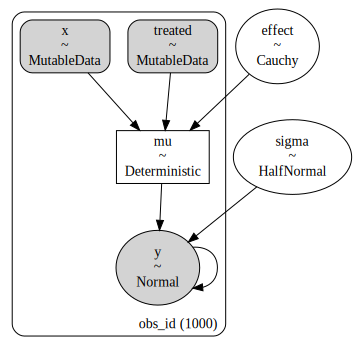

In [5]:
with pm.Model() as model:
    x = pm.MutableData("x", df.x, dims="obs_id")
    treated = pm.MutableData("treated", df.treated, dims="obs_id")
    sigma = pm.HalfNormal("sigma", 1)
    delta = pm.Cauchy("effect", alpha=0, beta=1)
    mu = pm.Deterministic("mu", x + (delta * treated), dims="obs_id")
    pm.Normal("y", mu=mu, sigma=sigma, observed=df.y, dims="obs_id")

pm.model_to_graphviz(model)

## Inference

In [6]:
with model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/pytensorf.py:1005: UserWarning: The parameter 'updates' of pytensor.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  pytensor_function = pytensor.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


We can see that we get no sampling warnings, and that plotting the MCMC traces shows no issues.

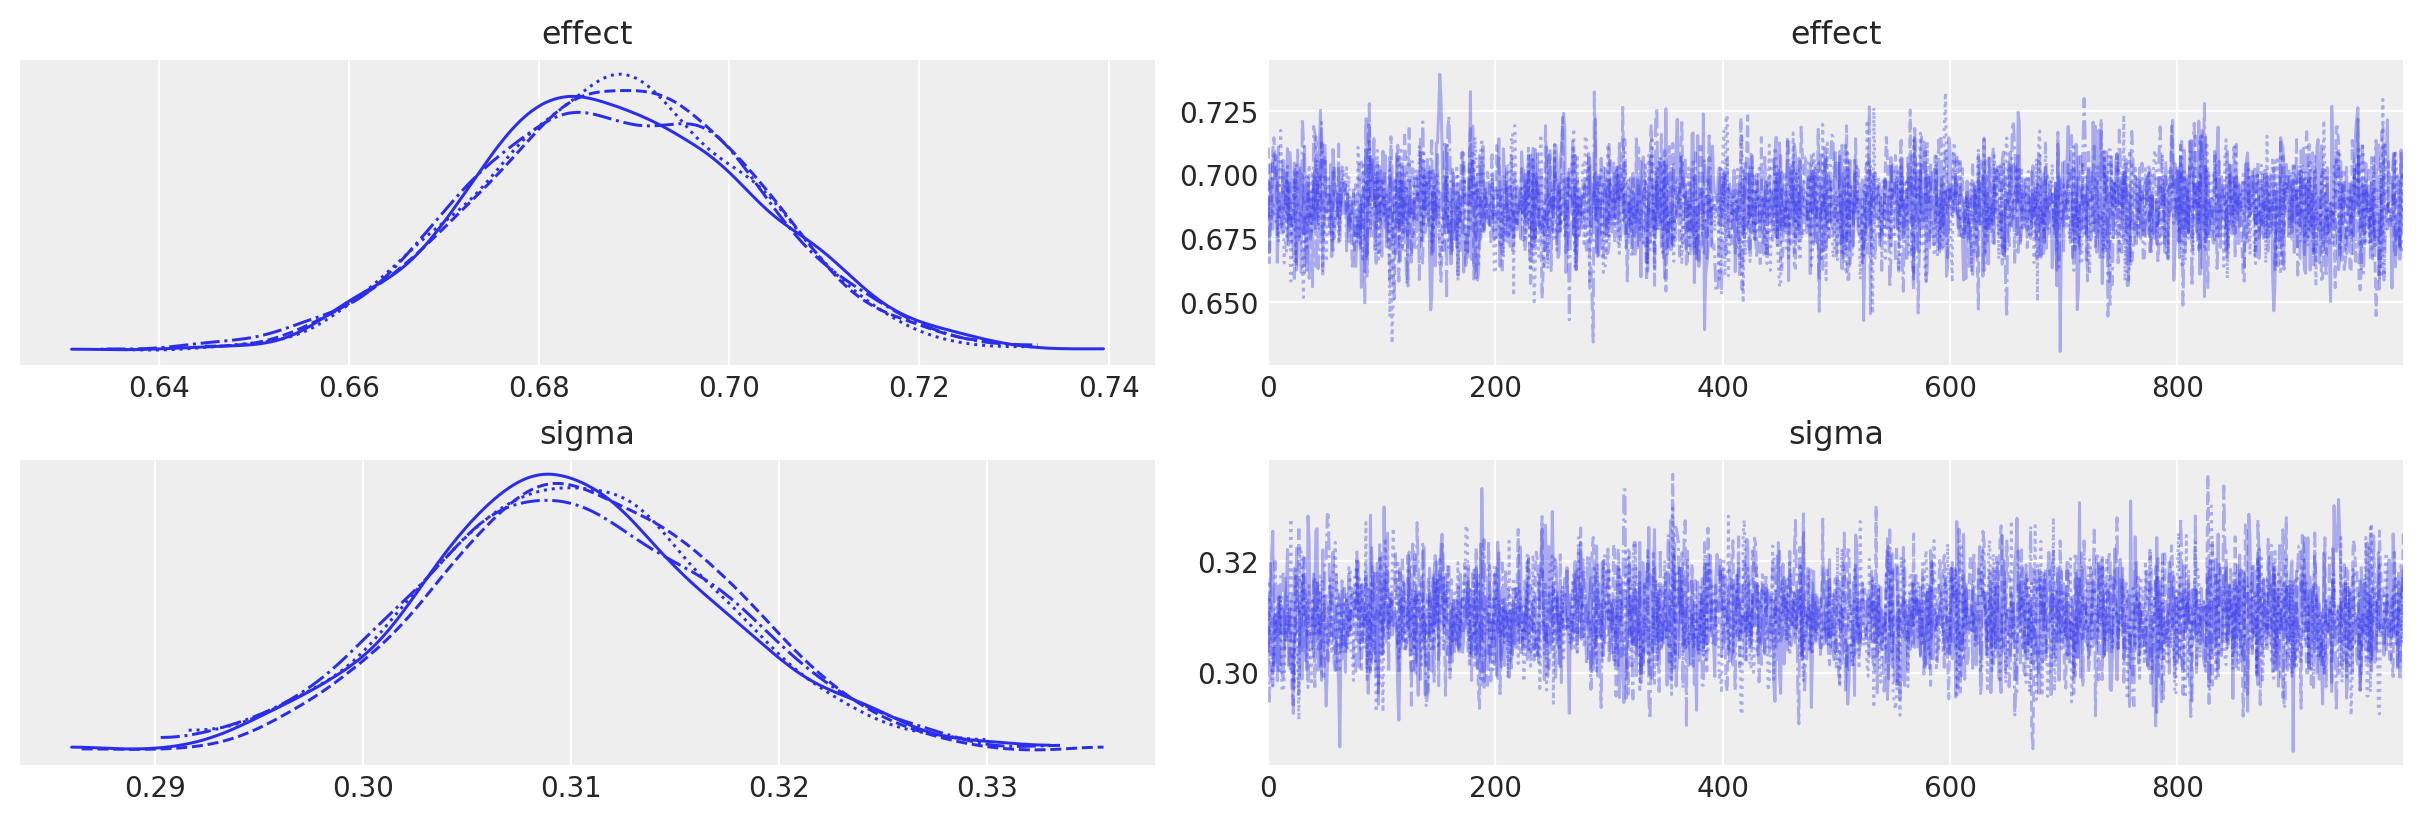

In [7]:
az.plot_trace(idata, var_names=["effect", "sigma"]);

We can also see that we are able to accurately recover the true discontinuity magnitude (left) and the standard deviation of the change in units between pre- and post-test (right).

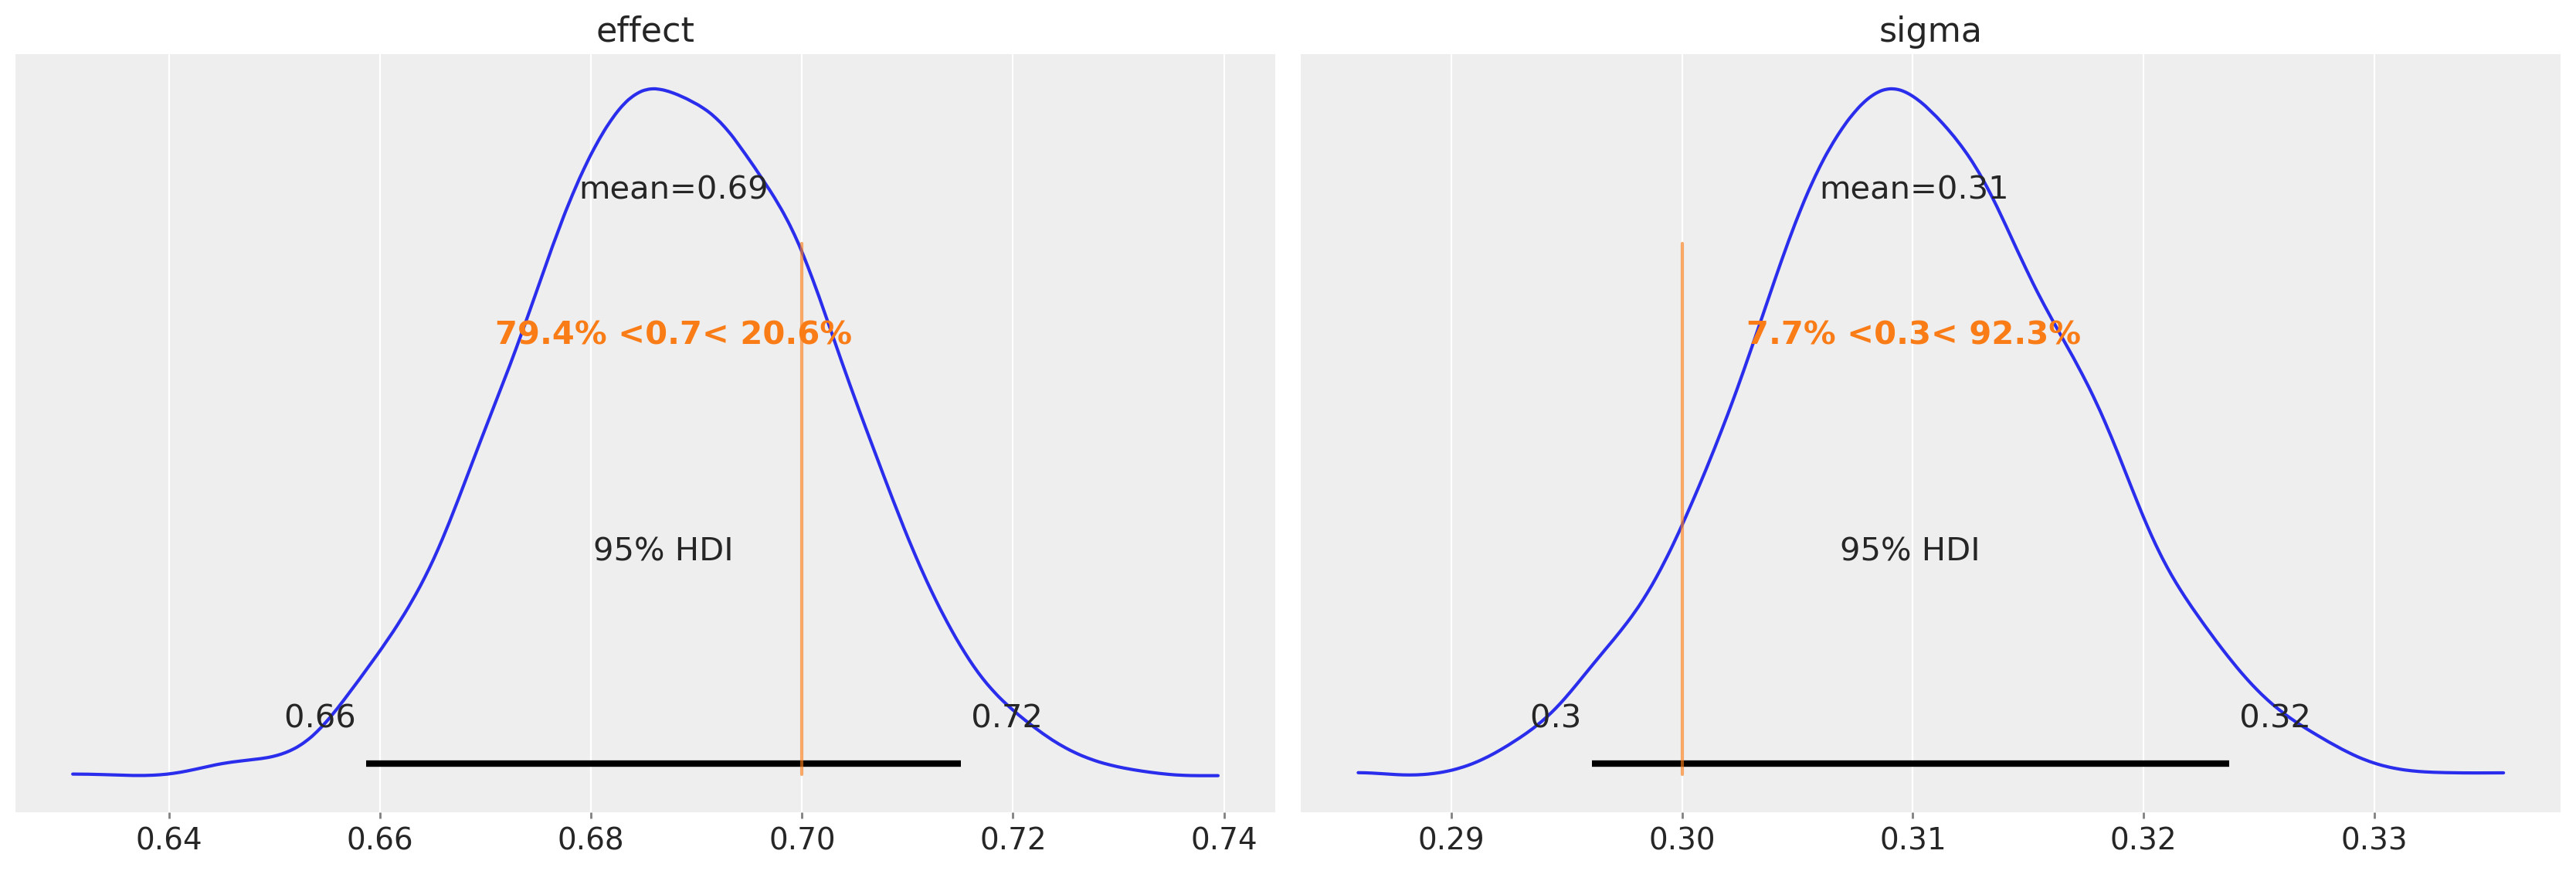

In [8]:
az.plot_posterior(
    idata, var_names=["effect", "sigma"], ref_val=[treatment_effect, sd], hdi_prob=0.95
);

The most important thing is the posterior over the `effect` parameter. We can use that to base a judgement about the strength of the effect (e.g. through the 95% credible interval) or the presence/absence of an effect (e.g. through a Bayes Factor or ROPE).

## Counterfactual questions

We can use posterior prediction to ask what would we expect to see if:
- no units were exposed to the treatment (blue shaded region, which is very narrow)
- all units were exposed to the treatment (orange shaded region).

_Technical note:_ Formally we are doing posterior prediction of `y`. Running `pm.sample_posterior_predictive` multiple times with different random seeds will result in new and different samples of `y` each time. However, this is not the case (we are not formally doing posterior prediction) for `mu`. This is because `mu` is a deterministic function (`mu = x + delta*treated`), so for our already obtained posterior samples of `delta`, the values of `mu` will be entirely determined by the values of `x` and `treated` data).

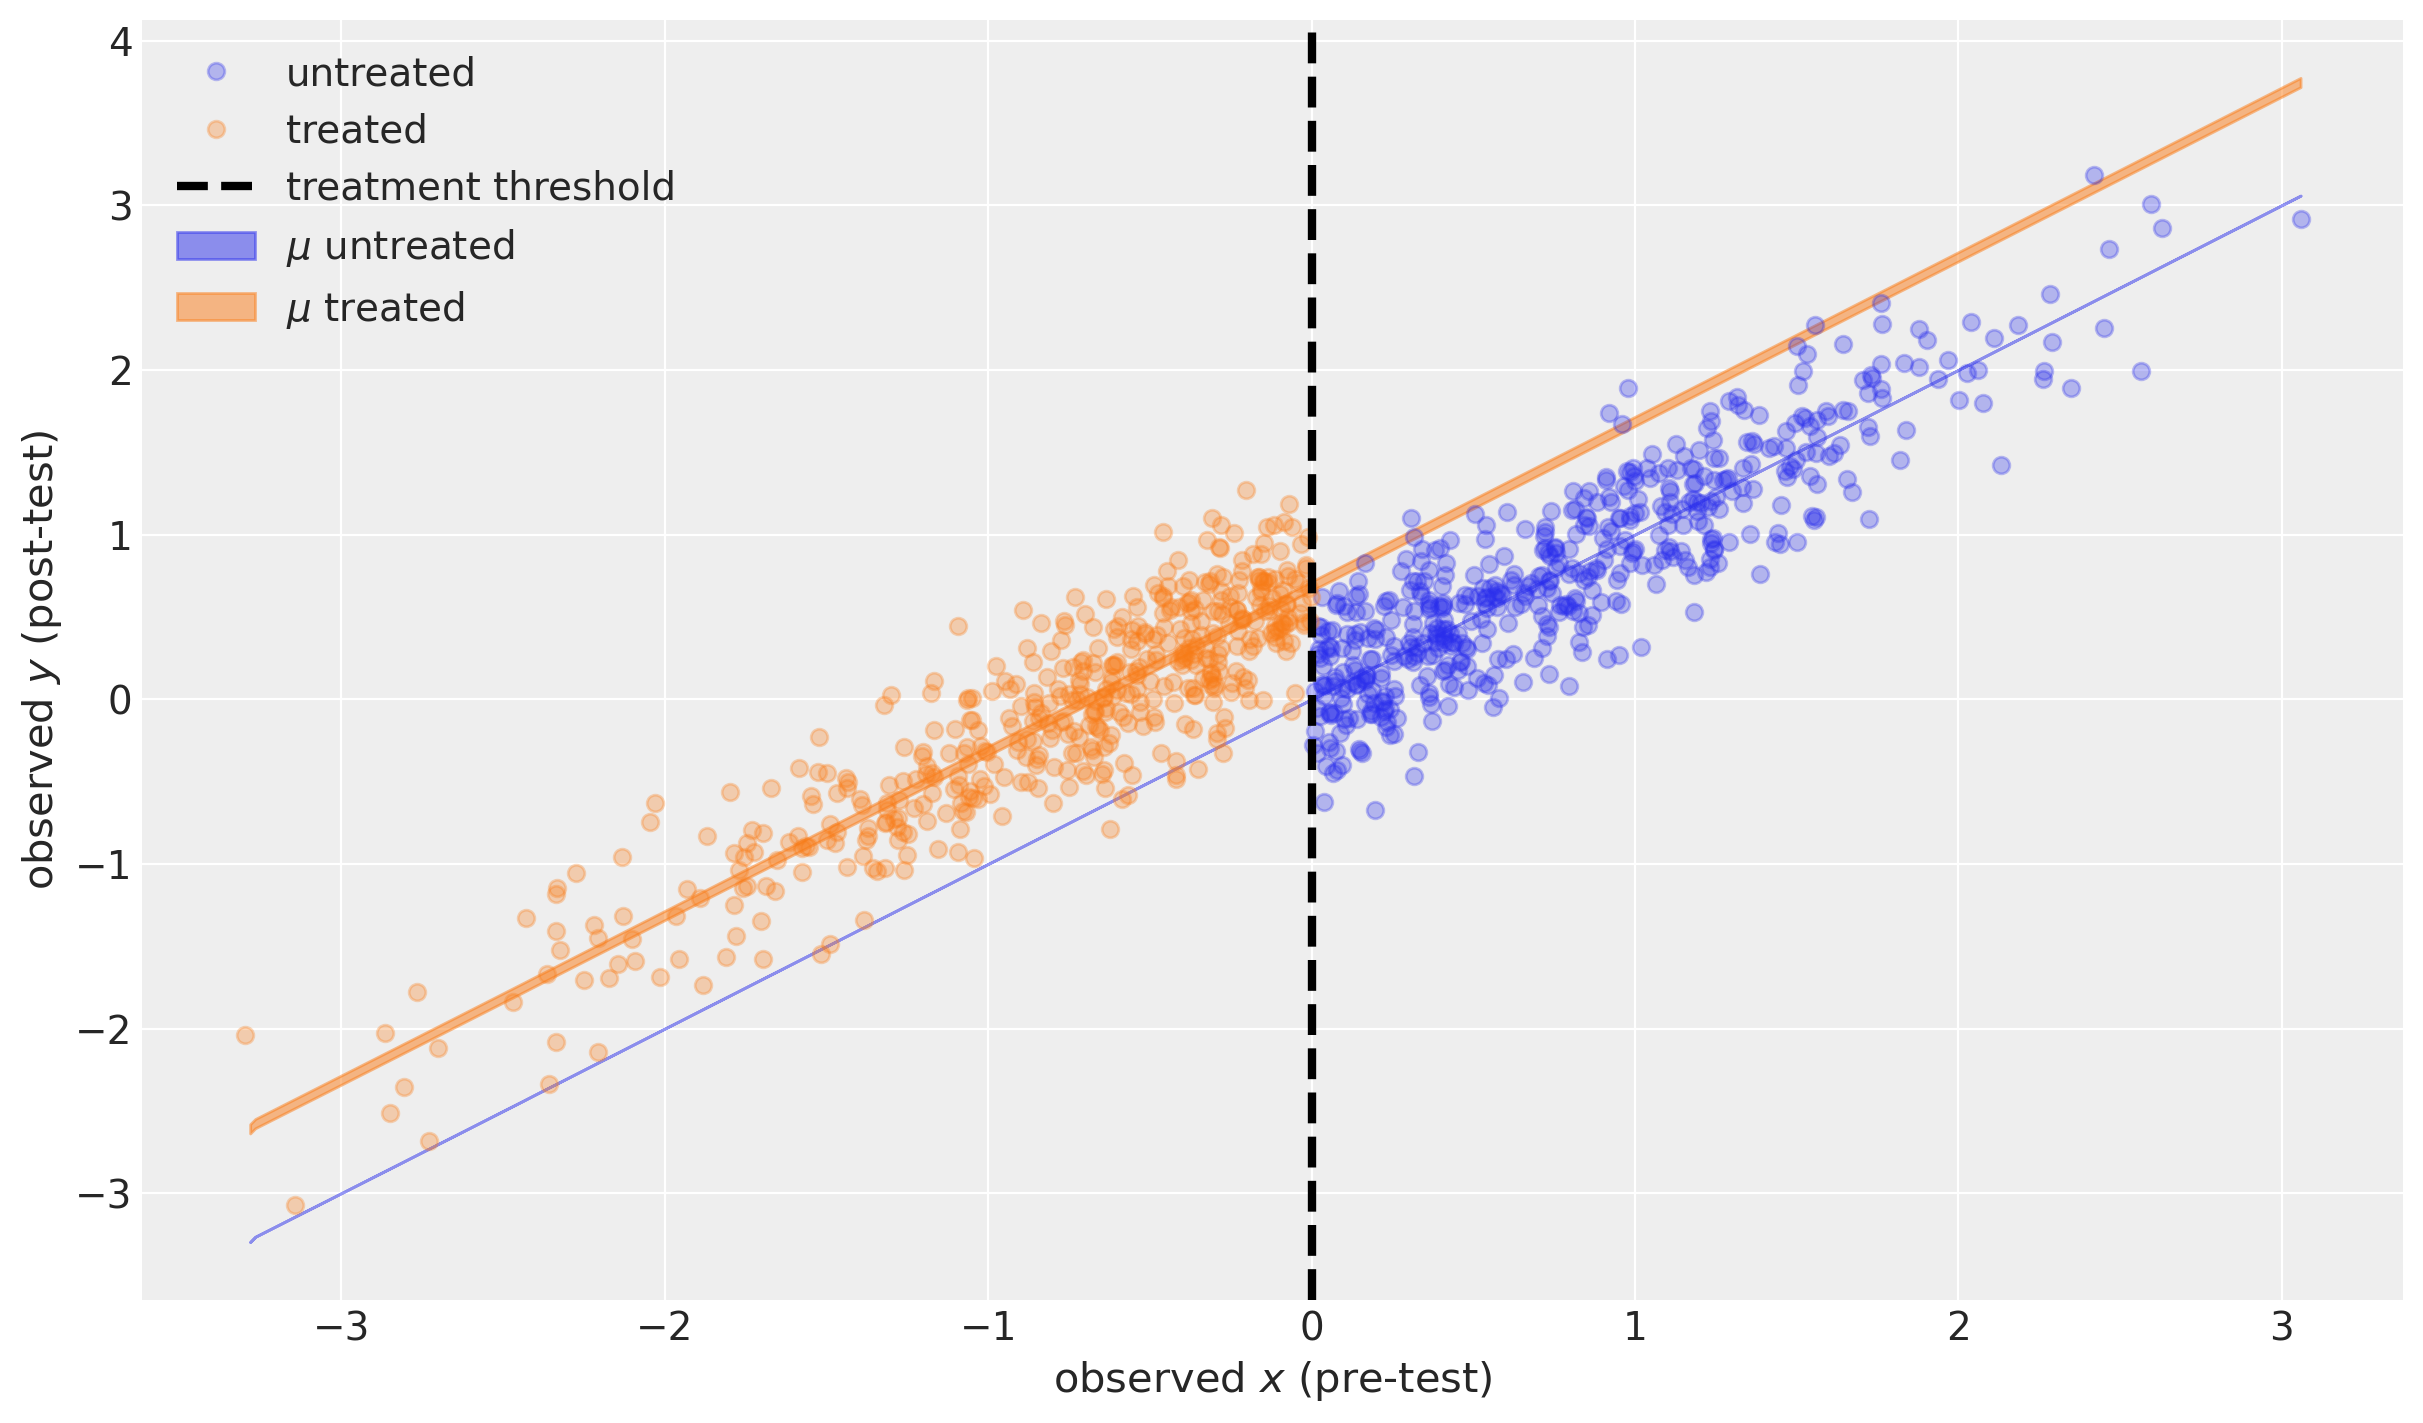

In [9]:
# MODEL EXPECTATION WITHOUT TREATMENT ------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.zeros(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
ax = plot_data(df)
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C0",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ untreated"},
)

# MODEL EXPECTATION WITH TREATMENT ---------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.ones(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C1",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ treated"},
)
ax.legend()

The blue shaded region shows the 95% credible region of the expected value of the post-test measurement for a range of possible pre-test measures, in the case of no treatment. This is actually infinitely narrow because this particular model assumes $\mu=x$ (see above).

The orange shaded region shows the 95% credible region of the expected value of the post-test measurement for a range of possible pre-test measures in the case of treatment.

Both are actually very interesting as examples of counterfactual inference. We did not observe any units that were untreated below the threshold, nor any treated units above the threshold. But assuming our model is a good description of reality, we can ask the counterfactual questions "What if a unit above the threshold was treated?" and "What if a unit below the threshold was treated?"

## Summary
In this notebook we have merely touched the surface of how to analyse data from regression discontinuity designs. Arguably, we have restricted our focus to almost the simplest possible case so that we can focus upon the core properties of the approach which allows causal claims to be made.

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in April 2022

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Thu Apr 21 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

pytensor: 2.5.1
aeppl : 0.0.27
xarray: 0.20.1

numpy     : 1.22.3
matplotlib: 3.5.1
arviz     : 0.12.0
pymc      : 4.0.0b6
pandas    : 1.4.2

Watermark: 2.3.0



:::{include} ../page_footer.md
:::